In [1]:
import os
os.chdir("/home/arne/devel/PycharmProjects/recursive-dependency-embedding")
from __future__ import print_function
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; } .output_svg > div { width: 100% !important; height: 100% !important; }</style>"))
# set full width and rescale svg to outer box
display(HTML("<style>.container { width:100% !important; } .output_svg > div { width: 100% !important; height: 100% !important; }</style>"))
import spacy
import preprocessing
#from preprocessing import read_data, read_data2, string_reader, get_word_embeddings, process_sentence2, process_sentence3, process_sentence4, addMissingEmbeddings
import constants
from IPython.display import Image
import visualize
import tools
import tensorflow_fold as td
import numpy as np
import corpus
from IPython.display import SVG

In [2]:
import fnmatch, ntpath
#train_data_path = '/media/arne/WIN/Users/Arne/ML/data/corpora/sick/process_sentence3/SICK_CMaggregate'
#train_data_path = '/media/arne/WIN/Users/Arne/ML/data/corpora/ppdb/process_sentence3_ns1/PPDB_CMaggregate'
train_data_path = '/media/arne/WIN/Users/Arne/ML/data/corpora/sick/process_sentence3/SICK_tt_CMaggregate'
parent_dir = os.path.abspath(os.path.join(train_data_path, os.pardir))
train_fnames = fnmatch.filter(os.listdir(parent_dir), ntpath.basename(train_data_path) + '.train.*')
train_fnames = [os.path.join(parent_dir, fn) for fn in train_fnames]
train_fnames

['/media/arne/WIN/Users/Arne/ML/data/corpora/sick/process_sentence3/SICK_tt_CMaggregate.train.0',
 '/media/arne/WIN/Users/Arne/ML/data/corpora/sick/process_sentence3/SICK_tt_CMaggregate.train.1']

In [3]:
types = corpus.read_types(train_data_path)

In [4]:
import train_fold, similarity_tree_tuple_pb2

def data_iterator(filename):
    return train_fold.iterate_over_tf_record_protos(
    [filename], similarity_tree_tuple_pb2.SimilarityTreeTuple, multiple_epochs=False)

train_iterator = data_iterator(train_fnames[0])
test_iterator = data_iterator(train_fnames[1])

In [5]:
from itertools import izip
def get_sentence_from_dep_sequence_node(dep_sequence_node):
    arrays = preprocessing.sequence_node_to_arrays(dep_sequence_node)
    texts = visualize.get_text(arrays, types)
    texts_pair = list(izip(*[iter(texts)]*2))
    return ' '.join([b for (a,b) in texts_pair])

In [6]:
texts_train = [(get_sentence_from_dep_sequence_node(similarity_tree_tuple['first']), get_sentence_from_dep_sequence_node(similarity_tree_tuple['second']), similarity_tree_tuple['similarity']) for similarity_tree_tuple in train_iterator]
print(str(len(texts_train)))
texts_test = [(get_sentence_from_dep_sequence_node(similarity_tree_tuple['first']), get_sentence_from_dep_sequence_node(similarity_tree_tuple['second']), similarity_tree_tuple['similarity']) for similarity_tree_tuple in test_iterator]
print(str(len(texts_test)))

4500
4927


In [40]:
def print_stats(texts_train, texts_test):
    train_sentences_first_unique = set([s1 for (s1, s2, sc) in texts_train])
    train_sentences_second_unique = set([s2 for (s1, s2, sc) in texts_train])
    print('train_sentences_first_unique:\t'+str(len(train_sentences_first_unique)))
    print('train_sentences_second_unique:\t'+str(len(train_sentences_second_unique)))
    train_sentences_unique = train_sentences_first_unique
    train_sentences_unique.update(train_sentences_second_unique)
    print('train_sentences_unique:\t'+str(len(train_sentences_unique)))

    train_tuple = [s1+s2 for (s1, s2, sc) in texts_train]
    print('train_tuple duplicates: '+ str(len(train_tuple) - len(set(train_tuple))))
    print('train_tuple unique: '+ str(len(set(train_tuple))))

    test_sentences_first_unique = set([s1 for (s1, s2, sc) in texts_test])
    test_sentences_second_unique = set([s2 for (s1, s2, sc) in texts_test])
    print('test_sentences_first_unique:\t'+str(len(test_sentences_first_unique)))
    print('test_sentences_second_unique:\t'+str(len(test_sentences_second_unique)))
    test_sentences_unique = test_sentences_first_unique
    test_sentences_unique.update(test_sentences_second_unique)
    print('test_sentences_unique:\t'+str(len(test_sentences_unique)))

    test_tuple = [s1+s2 for (s1, s2, sc) in texts_test]
    print('test_tuple duplicates: '+ str(len(test_tuple) - len(set(test_tuple))))
    print('test_tuple unique: '+ str(len(set(test_tuple))))

    sentences_unique = train_sentences_unique
    sentences_unique.update(test_sentences_unique)
    print('sentences_unique:\t'+str(len(sentences_unique)))
    
    tuple_unique = set(train_tuple)
    tuple_unique.update(set(test_tuple))
    print('tuple unique: '+ str(len(tuple_unique)))
    print('train/test tuple overlap: '+ str(len(set(train_tuple)) + len(set(test_tuple)) - len(tuple_unique)))

print_stats(texts_train, texts_test)

train_sentences_first_unique:	3146
train_sentences_second_unique:	3132
train_sentences_unique:	4802
train_tuple duplicates: 30
train_tuple unique: 4470
test_sentences_first_unique:	3393
test_sentences_second_unique:	3339
test_sentences_unique:	5007
test_tuple duplicates: 0
test_tuple unique: 4927
sentences_unique:	6066
tuple unique: 9348
train/test tuple overlap: 49


In [43]:
import csv
def sick_reader(filename):
    with open(filename, 'rb') as csvfile:
        reader = csv.DictReader(csvfile, delimiter='\t')
        for row in reader:
            yield row['sentence_A'].decode('utf-8'), row['sentence_B'].decode('utf-8'), float(row['relatedness_score'])

In [45]:
texts_train_orig = list(sick_reader('/home/arne/devel/ML/data/corpora/SICK/sick_train/SICK_train.txt'))
texts_test_orig = list(sick_reader('/home/arne/devel/ML/data/corpora/SICK/sick_test_annotated/SICK_test_annotated.txt'))
print_stats(texts_train_orig, texts_test_orig)

train_sentences_first_unique:	3146
train_sentences_second_unique:	3132
train_sentences_unique:	4802
train_tuple duplicates: 30
train_tuple unique: 4470
test_sentences_first_unique:	3393
test_sentences_second_unique:	3339
test_sentences_unique:	5007
test_tuple duplicates: 0
test_tuple unique: 4927
sentences_unique:	6066
tuple unique: 9348
train/test tuple overlap: 49


similarity: 4.5
A group of kids is playing in a yard and an old man is standing in the background .


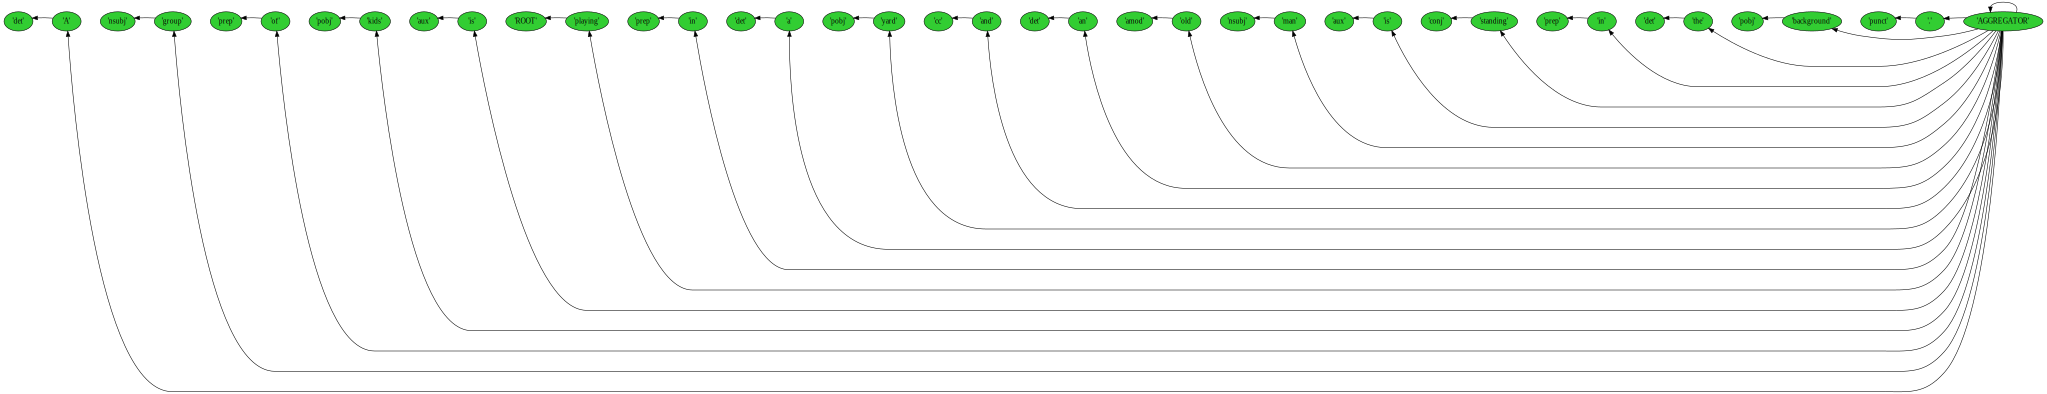

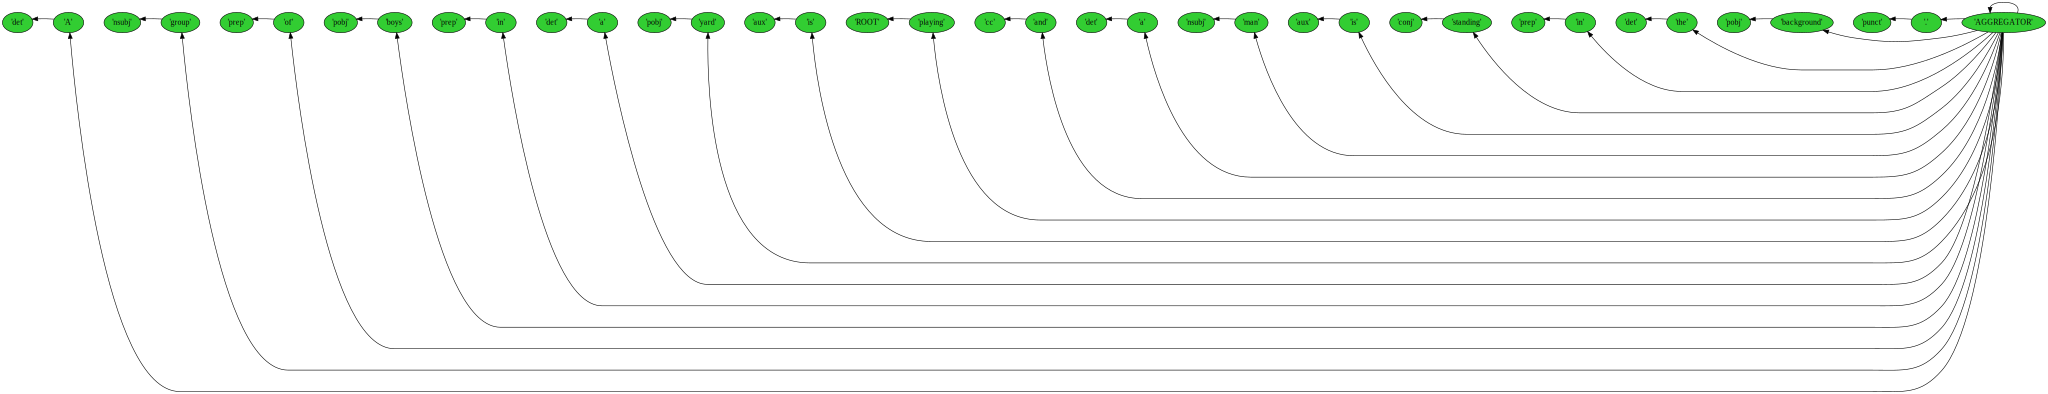

In [10]:
#from itertools import izip

similarity_tree_tuple = train_iterator.next()
#trees = []
#trees.append(preprocessing.sequence_node_to_arrays(similarity_tree_tuple['first']))
#trees.append(preprocessing.sequence_node_to_arrays(similarity_tree_tuple['second']))
sim = similarity_tree_tuple['similarity'] * 4.0 + 1.0
print('similarity: '+str(sim))
#texts = [None, None]
#texts[0] = visualize.get_text(trees[0], types)
#texts[1] = visualize.get_text(trees[1], types)
#texts_pair = [None, None]
#texts_pair[0] = list(izip(*[iter(texts[0])]*2))
#texts_pair[1] = list(izip(*[iter(texts[1])]*2))
#print(' '.join([b for (a,b) in texts_pair[0]]))
#print(', '.join([a for (a,b) in texts_pair[0]]))
#print(' '.join([b for (a,b) in texts_pair[1]]))
#print(', '.join([a for (a,b) in texts_pair[1]]))
print(get_sentence_from_dep_sequence_node(similarity_tree_tuple['first']))
visualize.visualize('forest_temp1.svg', trees[0], types)
display(SVG('forest_temp1.svg'))
visualize.visualize('forest_temp2.svg', trees[1], types)
display(SVG('forest_temp2.svg'))
#similarity_tree_tuple

In [8]:
nlp = spacy.load('en')
nlp.pipeline = [nlp.tagger, nlp.entity, nlp.parser]

In [3]:
print('extract word embeddings from spaCy...')
#vecs, ids, types = preprocessing.get_word_embeddings(nlp.vocab)
vecs, types = corpus.create_or_read_dict('dict_temp', vocab=nlp.vocab)
mapping = corpus.mapping_from_list(types)

extract word embeddings from spaCy...


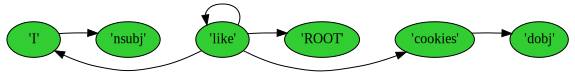

[117, 1297617, 152, 53151, 5605, 1297620]
[2, -1, 0, -1, -2, -1]


In [8]:

reload(visualize)
reload(preprocessing)
#sentence = 'London is a big city in the United Kingdom.'
#sentence = 'He is a big city in the United Kingdom.'
sentence = 'I like cookies'
#sentence = 'The Philippine Fault System is an inter-related system of faults throughout the whole of the Philippine Archipelago, primarily caused by tectonic forces compressing the Philippines into what tectonic geophysicists call the Philippine Mobile Belt. '

#(seq_data, seq_parents, root) = read_sentence2('A very shy monkey is practicing martial arts. I like this.', True) 
seq_data, seq_parents, _ = preprocessing.read_data(preprocessing.string_reader, preprocessing.process_sentence3, nlp, mapping, args={'content': sentence}, concat_mode='sequence', inner_concat_mode='tree')
#new_embeddings, added_count = addMissingEmbeddings(seq_data, vecs)
#new_embeddings, added_count = addMissingEmbeddings(seq_data, new_embeddings)
#vecs = new_embeddings

types = corpus.revert_mapping_to_list(mapping)

#new_seq_data, new_ids, new_vecs, new_counts, new_types = preprocessing.sort_embeddings(seq_data, ids, vecs, types, nlp.vocab)

visualize.visualize('forest_temp.svg', (seq_data, seq_parents), types)
#visualize.visualize('forest_temp.svg', (seq_data[10:18], seq_parents[10:18]), types)
#visualize.visualize('forest_temp.svg', (seq_data[30:40], seq_parents[30:40]), types)
#visualize.visualize('forest_temp.svg', (seq_data[10:], seq_parents[10:]), types)
#visualize.visualize('forest_temp.png', (seq_data[48:66], seq_parents[48:66]), types)
#img = Image('forest_temp.svg')
#display(img)
display(SVG('forest_temp.svg'))

print(seq_data.tolist())
print(seq_parents.tolist())

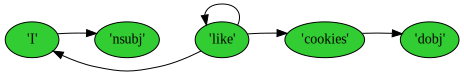

In [9]:
seq_data = [117, 1297617, 152, 5605, 1297620]
seq_parents = [2, -1, 0, -1, -1]

visualize.visualize('forest_temp.svg', (seq_data, seq_parents), types)
#visualize.visualize('forest_temp.svg', (seq_data[10:18], seq_parents[10:18]), types)
#visualize.visualize('forest_temp.svg', (seq_data[30:40], seq_parents[30:40]), types)
#visualize.visualize('forest_temp.svg', (seq_data[10:], seq_parents[10:]), types)
#visualize.visualize('forest_temp.png', (seq_data[48:66], seq_parents[48:66]), types)
#img = Image('forest_temp.svg')
#display(img)
display(SVG('forest_temp.svg'))

In [7]:
children, roots = preprocessing.children_and_roots(seq_parents)
seq_tree = preprocessing.build_sequence_tree(seq_data, children, roots[0])
seq_tree

head: 145
children {
  head: 117
  children {
    head: 3646
    children {
      head: 1297620
    }
  }
  children {
    head: 53146
  }
  children {
    head: 853
    children {
      head: 112
      children {
        head: 48
      }
    }
    children {
      head: 385
      children {
        head: 1297621
      }
    }
    children {
      head: 43
    }
    children {
      head: 120
      children {
        head: 60
      }
      children {
        head: 7453
        children {
          head: 109
          children {
            head: 48
          }
        }
        children {
          head: 2014
          children {
            head: 9123
          }
        }
        children {
          head: 1297622
        }
      }
    }
  }
  children {
    head: 70
    children {
      head: 62
    }
  }
}
children {
  head: 110
  children {
    head: 1297620
  }
}
children {
  head: 53146
}
children {
  head: 139
  children {
    head: 1297623
  }
}
children {
  head: 70
  childre

In [ ]:
train_path = '/media/arne/WIN/Users/Arne/ML/data/corpora/wikipedia/process_sentence8/WIKIPEDIA_articles10000_offset0'
types = corpus.read_types(train_path)
mapping = corpus.mapping_from_list(types)

seq_data_loaded = np.load(train_path + '.data')
seq_parents_loaded = np.load(train_path + '.parent')
children_loaded, roots_loaded = preprocessing.children_and_roots(seq_parents_loaded)
visualize.visualize('forest_temp.png', (seq_data_loaded, seq_parents_loaded), token_list)
img = Image('forest_temp.png')
display(img)

In [22]:
#ROOT_DIR = os.path.dirname(os.path.abspath(__file__))
ROOT_DIR = '/home/arne/devel/PycharmProjects/recursive-dependency-embedding'
td.proto_tools.map_proto_source_tree_path('', ROOT_DIR)
td.proto_tools.import_proto_file('sequence_node.proto')
tree_ = td.proto_tools.serialized_message_to_tree('recursive_dependency_embedding.SequenceNode', seq_tree.SerializeToString())

new_data, new_parents = preprocessing.sequence_tree_to_arrays(tree_)

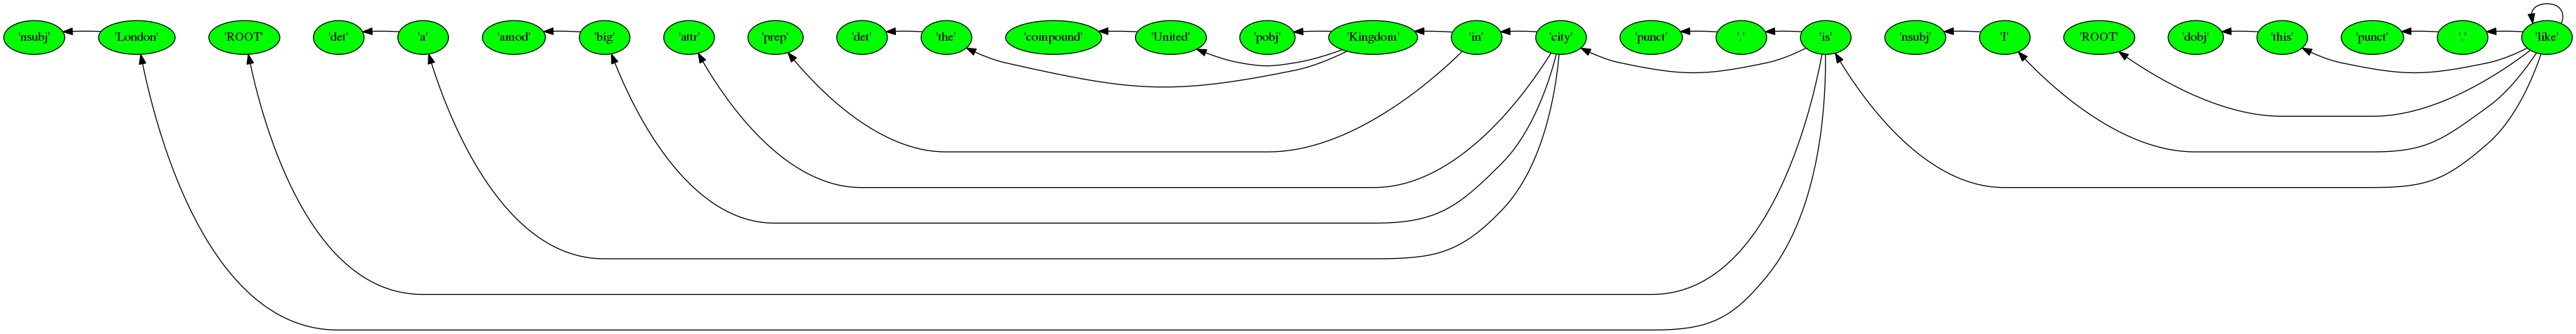

In [23]:
data_maps_reverse = tools.revert_mapping(data_maps2)

visualize.visualize('forest_temp.png', (new_data, new_parents), data_maps_reverse, nlp.vocab, constants.vocab_manual)
img = Image('forest_temp.png')
display(img)

In [7]:
preprocessing.read_data_2(preprocessing.string_reader, preprocessing.process_sentence2, nlp, data_maps2, args={'content': sentence}, max_depth=10)#, concat_mode='sequence')

start read_data ...
sentences read: 1


(array([   160,  58435,  39617,   6156,    117,    166,  15966,    141,
          1160,    486,    114,  12252,   2185,    109,    431,    114,
           109,  58435,  72660,     67,   3969,   1848,    188,  50708,
          2629,  37639,    109,  14540,    229,    167,  50708, 335812,
           476,    109,  58435,   7221,  16450,     70]),
 array([  3,   2,   1,   1,   0,   4,   2,   1,   1,  -5,  -1,  -1,  -1,
          1,  -2,  -1,   2,   1,  -3,  -8,   1, -10,  -1,   1,  -2,  -1,
          1,  -2,  -3,   3,   1,   1,  -4,   3,   2,   1,  -4, -33]),
 array([[32, 29,  1],
        [32, 31,  1],
        [32, 30,  2],
        [32, 36,  1],
        [32, 33,  2],
        [32, 34,  2],
        [32, 35,  2],
        [ 3,  0,  1],
        [ 3,  1,  1],
        [ 3,  2,  1],
        [ 4,  3,  1],
        [ 4,  0,  2],
        [ 4,  1,  2],
        [ 4,  2,  2],
        [ 4,  9,  1],
        [ 4,  5,  2],
        [ 4,  8,  2],
        [ 4,  6,  3],
        [ 4,  7,  3],
        [ 4, 10,  2]

In [8]:
import corpus_wikipedia
import numpy as np

children, roots = preprocessing.children_and_roots(seq_parents)
print(children)
print('calc depths ...')
depth = -np.ones(len(seq_data), dtype=np.int32)
for idx in range(len(seq_data)):
    if depth[idx] < 0:
        corpus_wikipedia.calc_depth(children, depth, idx)
print(depth)

{8: [6, 7], 1: [0, 4, 9], 11: [1, 10, 12, 13], 4: [2, 3, 5], 5: [8]}
calc depths ...
[0 4 0 0 3 2 0 0 1 0 0 5 0 0]


In [7]:
from preprocessing import build_sequence_tree, children_and_roots
children, roots = children_and_roots(seq_parents)
seq_tree = build_sequence_tree(seq_data, children, root)
seq_tree

head: 145
children {
  head: 5593
  children {
    head: 6313
    children {
      head: 291
      children {
        head: 48
      }
    }
    children {
      head: 5132
      children {
        head: 234
        children {
          head: 1297613
        }
      }
      children {
        head: 1297614
      }
    }
    children {
      head: 1297615
    }
  }
  children {
    head: 117
    children {
      head: 44
    }
  }
  children {
    head: 53146
  }
  children {
    head: 5353
    children {
      head: 7686
      children {
        head: 1297614
      }
    }
    children {
      head: 1297616
    }
  }
  children {
    head: 70
    children {
      head: 62
    }
  }
}
children {
  head: 110
  children {
    head: 1297615
  }
}
children {
  head: 53146
}
children {
  head: 139
  children {
    head: 1297616
  }
}
children {
  head: 70
  children {
    head: 62
  }
}

In [2]:
import tensorflow_fold as td
import tensorflow as tf
import numpy as np

embeddings_np = np.load('data/nlp/spacy/dict.vecs')[]
embedding_dim = embeddings_np.shape[1]
lex_size = 1300000
#print('load mappings from: ' + data_fn + '.mapping ...')
#mapping = pickle.load(open(data_fn + '.mapping', "rb"))
assert lex_size >= embeddings_np.shape[0], 'len(embeddings) > lex_size. Can not cut the lexicon!'
embeddings_padded = np.lib.pad(embeddings_np, ((0, lex_size - embeddings_np.shape[0]), (0, 0)), 'mean')

print('embeddings_np.shape: '+str(embeddings_np.shape))
print('embeddings_padded.shape: ' + str(embeddings_padded.shape))

embeddings_np.shape: (1297614, 300)
embeddings_padded.shape: (1300000, 300)


In [4]:
with tf.Graph().as_default():
    W = tf.Variable(tf.constant(0.0, shape=[lex_size, embedding_dim]),
                            trainable=False, name="W")

    embedding_placeholder = tf.placeholder(tf.float32, [lex_size, embedding_dim])
    embedding_init = W.assign(embedding_placeholder)
    a = tf.placeholder(tf.float32)
    
    sess = tf.Session()
    sess.run(embedding_init, feed_dict={embedding_placeholder: embeddings_padded})

In [12]:
embeds = td.Embedding(10000, 300, name='head_embed')

x = sequence_tree_block(300, embeds)
x.eval(seq_tree)
#seq_tree

AttributeError: 'ForwardDeclaration' object has no attribute 'eval'

In [12]:
import tensorflow_fold as td
import tensorflow as tf

lex_size = 5
state_size = 10

expr_decl = td.ForwardDeclaration(td.PyObjectType(), state_size)

# get the head embedding from id
def head(name_):
     return td.Pipe(td.Scalar(dtype='int32'), 
               td.Function(td.Embedding(lex_size, state_size, name='head_embed')), 
               name=name_)
# get the weighted sum of all children
def children_aggr(name_):
     return td.Pipe(td.Map(expr_decl()), 
                        td.Map(td.Function(lambda x: tf.norm(x) * x)), 
                        td.Reduce(td.Function(tf.add)), 
                        name=name_)

#dummy = td.con

gru_cell = td.ScopedLayer(tf.contrib.rnn.GRUCell(num_units=state_size), 'mygru')

#def aggr_op():
#    return (td.Record([('head', head), ('children', children_aggr)]) >>
#              td.Concat() >>
#              td.FC(state_size, name='FC_aggr'))
    #return ([children_aggr] >> td.RNN(gru_cell, initial_state=head))
    #return (children_aggr)

def cas(seq_tree):    
    # process and aggregate
    if len(seq_tree['children']) > 0 and seq_tree['head'] is not None:
        return 0
    # dont process children
    if len(seq_tree['children']) == 0:
        return 1
    # process children only
    return 2
    
    
cases = td.OneOf(lambda x: cas(x),
                     {1: td.Record([('head', head('head') >> td.Broadcast()), ('children', children_aggr('children_aggr') >> td.Broadcast())]) 
                      >> td.Zip() 
                      >> td.Reduce(td.Function(tf.add)), #td.RNN(gru_cell, initial_state_from_input=True),
                      2: td.GetItem('head') >> td.Optional(head('just_head')),
                      3: td.GetItem('children') >> children_aggr('just_children')})


expr_decl.resolve_to(cases)

In [ ]:
cases2 = td.OneOf(lambda x: cas(x),
                     {1: td.Record([('head', head('head') >> td.Broadcast()), ('children', children_aggr('children_aggr') >> td.Broadcast())]) 
                      >> td.Zip() 
                      >> td.Reduce(td.Function(tf.add)), #td.RNN(gru_cell, initial_state_from_input=True),
                      2: td.GetItem('head') >> td.Optional(head('just_head'))})

In [25]:
import numpy as np
def calc_embedding_avg(seq):
    seq_data, seq_types, seq_parents, seq_edges = seq
    e = np.zeros(nlp.vocab.vectors_length) # TODO: check dim of embeddings!
    for i in range(len(seq_data)):
        e += data_vecs[seq_types[i]][seq_data[i]]
    return e / len(seq_data) # average

In [26]:
calc_embedding_avg(read_sentence('A very shy monkey is practicing martial arts.'))

array([  1.07410002e-02,   1.04797661e-01,  -9.15853009e-02,
        -5.72742199e-02,   1.87026666e-01,  -2.82920011e-02,
         3.37927755e-02,  -1.95071244e-01,  -3.40955622e-03,
         2.12087999e+00,  -1.69830299e-01,   1.09519947e-02,
        -6.34260000e-02,  -1.11622448e-01,  -1.12552635e-02,
         1.59957554e-01,   1.04001443e-01,   8.65459439e-01,
        -2.38412996e-01,   5.50149985e-02,  -7.51673329e-02,
        -1.80346219e-01,  -8.34840544e-02,  -1.11868726e-01,
         8.09453333e-02,  -6.86778910e-02,  -1.04682251e-02,
        -4.30825555e-02,   6.12711095e-02,  -2.60911190e-01,
        -4.86684436e-02,   4.19144664e-03,   1.84042576e-01,
        -2.16793002e-01,   1.31033664e-01,  -8.43688916e-02,
         6.11080002e-02,  -5.91083342e-02,  -1.17230153e-01,
        -3.09220557e-01,   1.51952467e-01,   1.42462335e-01,
         1.21541668e-01,  -3.40155537e-02,   2.18288891e-01,
         2.27417561e-01,  -7.52422234e-02,   5.98678859e-02,
        -1.67224473e-02,

In [29]:
doc = nlp(u"Apples and oranges are ASdjkhaksdhkahd. Boots and hippos aren't.")

apples = doc[0]
oranges = doc[2]
boots = doc[6]
hippos = doc[8]

In [31]:
doc[4].orth

1510419

In [32]:
doc2 = nlp(u"Hello you ASdjkhaksdhkahd.")
doc2[2].orth

1510419

In [33]:
len(doc.vocab)

1297627

In [ ]:
#TODO: